In [ ]:
import torch
import numpy as np

## 3.1 Автоматическое дифференцирование в `torch`

3.1.1 Воспользовавшись классами `Neuron` и `SquaredLoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [ ]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [ ]:
class SquaredLoss:
    def forward(self, y_pred, y_true):
        self.loss = (y_pred - y_true) ** 2
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
class Neuron:
    def __init__(self, n_inputs):
        self.weights = torch.randn(n_inputs, requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)

    def forward(self, inputs):
        return torch.dot(self.weights, inputs) + self.bias

    def backward(self):
        self.dweights = self.weights.grad # df/dW
        self.dbias = self.bias.grad # df/db

In [ ]:
torch.randn(6, requires_grad=True), torch.randn(1, requires_grad=True)

(tensor([-9.8827e-01, -1.4655e-04,  9.4005e-01, -9.5339e-01,  5.7831e-01,
          8.3799e-01], requires_grad=True),
 tensor([-1.5911], requires_grad=True))

In [ ]:
import random

n_inputs = X.shape[-1] # <размерность элемента выборки >
lr = 0.002 #  скорость обучения
n_epoch = 100 #  количество эпох

neuron = Neuron(n_inputs)

loss = SquaredLoss()


for epoch in range(n_epoch):
    losses = []
    for x_example, y_example in zip(X, y):
        y_pred = neuron.forward(x_example)
        loss.forward(y_pred, y_example) # <прогон через функцию потерь>

        losses.append(loss.loss.item())

        loss.backward()
        neuron.backward()

        # градиентный спуск
        with torch.no_grad():
            neuron.weights -= lr * neuron.weights.grad
            neuron.bias -= lr * neuron.dbias



        neuron.weights.grad.zero_()
        neuron.bias.grad.zero_()

    if epoch%10==0:
        print(f'epoch {epoch} mean loss {sum(losses) / len(losses)}')

epoch 0 mean loss 11308.749487757683
epoch 10 mean loss 8.873891422476737
epoch 20 mean loss 0.027339617786492455
epoch 30 mean loss 0.0001891621524191578
epoch 40 mean loss 1.6268958462717364e-06
epoch 50 mean loss 6.890364405265359e-08
epoch 60 mean loss 4.5067021885447644e-08
epoch 70 mean loss 4.5048650092471834e-08
epoch 80 mean loss 4.5048650092471834e-08
epoch 90 mean loss 4.5048650092471834e-08


3.1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
class MSELoss:
    def forward(self, y_pred, y_true):
        self.loss = ((y_pred.view(-1, 1) - y_true.view(-1, 1)) ** 2).mean()
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
class ReLU:
    def forward(self, inputs):
        self.output = inputs.clip(min=0)
        return self.output

In [ ]:
class Linear:
    def __init__(self, n_features, n_neurons):
        # <создать атрибуты объекта weights и biases>
        self.weights = torch.randn(n_features, n_neurons, requires_grad=True)
        self.bias = torch.randn(n_neurons, requires_grad=True)

    def forward(self, inputs):
        return torch.matmul(inputs, self.weights) + self.bias # <реализовать логику слоя>

    def backward(self):
        self.dweights = self.weights.grad # df/dW
        self.dbias = self.bias.grad # df/db

In [ ]:
y[:10]

tensor([[0.0838],
        [0.0853],
        [0.1769],
        [0.2307],
        [0.2791],
        [0.4044],
        [0.4606],
        [0.4826],
        [0.4931],
        [0.5548]])

In [ ]:
# создание компонентов сети
fc1 = Linear(X.shape[1], 5)
relu1 = ReLU()
fc2 = Linear(5, 1)
loss = MSELoss()

lr = 0.01

ys = []
losses = []
for epoch in range(11):

    y_pred = fc2.forward(relu1.forward(fc1.forward(X)))

    data_loss = loss.forward(y_pred, y) # <прогон через функцию потерь>
    losses.append(data_loss.item())
    if epoch % 2 == 0:
        print(f'epoch {epoch} mean loss {data_loss}')
        ys.append(y_pred)

    # <backprop>
    # loss > fc2 > relu1 > fc1
    loss.backward()
    fc2.backward()
    fc1.backward()

    # <шаг оптимизации для fc1>
    with torch.no_grad():
        fc1.weights -= lr * fc1.dweights
        fc1.bias -= lr * fc1.dbias

    # <шаг оптимизации для fc2>
    with torch.no_grad():
        fc2.weights -= lr * fc2.dweights
        fc2.bias -= lr * fc2.dbias

    # <обнуляем градиент для fc1>
    fc1.weights.grad.zero_()
    fc1.bias.grad.zero_()

    # <обнуляем градиент для fc2>
    fc2.weights.grad.zero_()
    fc2.bias.grad.zero_()

epoch 0 mean loss 1.7175019979476929
epoch 2 mean loss 1.0090845823287964
epoch 4 mean loss 0.6366785764694214
epoch 6 mean loss 0.43772682547569275
epoch 8 mean loss 0.32941994071006775
epoch 10 mean loss 0.26878392696380615


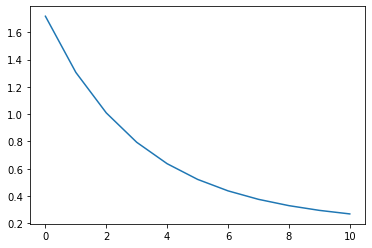

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses);

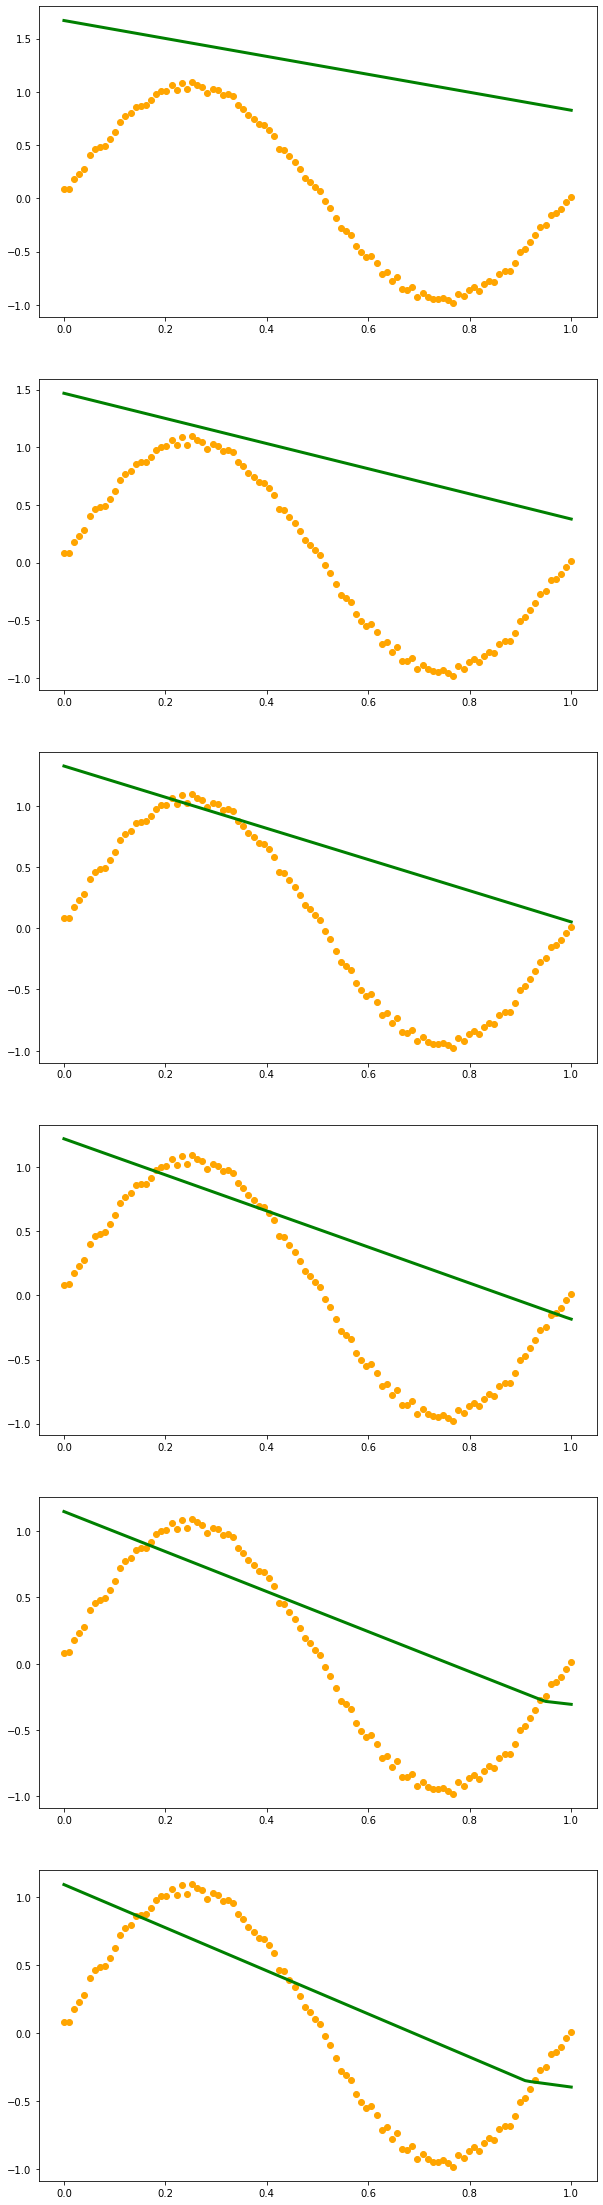

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(ys), 1, figsize=(10, 40))
for ax, y_ in zip(axs, ys):
    ax.scatter(X.numpy(), y.numpy(), color = "orange")
    ax.plot(X.numpy(), y_.detach().numpy(), 'g-', lw=3)

## 3.2 Алгоритмы оптимизации в `torch.optim`

In [ ]:
import torch.optim as optim

3.2.1 Решить задачу 3.1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

In [ ]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [ ]:
class SquaredLoss:
    def forward(self, y_pred, y_true):
        self.loss = ((y_pred - y_true) ** 2).mean()
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
class Neuron:
    def __init__(self, n_inputs):
        self.weights = torch.randn(n_inputs, requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)

    def forward(self, inputs):
        return torch.dot(self.weights, inputs) + self.bias

In [ ]:
import random

n_inputs = 4 # <размерность элемента выборки >
lr = 0.01 #  скорость обучения
n_epoch = 100 #  количество эпох

neuron = Neuron(n_inputs)
loss = SquaredLoss()

optimizer = torch.optim.SGD([neuron.weights, neuron.bias], lr=lr)

for epoch in range(n_epoch):
    losses = []
    for x_example, y_example in zip(X, y):
        # forward pass

        y_pred = neuron.forward(x_example) # <прогон через нейрон>
        curr_loss = loss.forward(y_pred, y_example) # <прогон через функцию потерь>
        losses.append(curr_loss)

        # backprop
        loss.backward()

        #optimizer
        optimizer.step()
        optimizer.zero_grad()



    if epoch%10==0:
        print(f'epoch {epoch} mean loss {sum(losses) / len(losses)}')
    # <вызов методов backward>
    # обратите внимание на последовательность вызовов: от конца к началу

    # <шаг оптимизации для весов (weights и bias) нейрона>

epoch 0 mean loss 4356.1923828125
epoch 10 mean loss 9.104986764540968e-10
epoch 20 mean loss 2.4418583821628204e-10
epoch 30 mean loss 2.4418583821628204e-10
epoch 40 mean loss 2.4418583821628204e-10
epoch 50 mean loss 2.4418583821628204e-10
epoch 60 mean loss 2.4418583821628204e-10
epoch 70 mean loss 2.4418583821628204e-10
epoch 80 mean loss 2.4418583821628204e-10
epoch 90 mean loss 2.4418583821628204e-10


3.2.2 Решить задачу 3.1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
class MSELoss:
    def forward(self, y_pred, y_true):
        self.loss = ((y_pred.view(-1, 1) - y_true.view(-1, 1)) ** 2).mean()
        return self.loss

    def backward(self):
        self.loss.backward()

In [ ]:
class ReLU:
    def forward(self, inputs):
        self.output = inputs.clip(min=0)
        return self.output

In [ ]:
class Linear:
    def __init__(self, n_features, n_neurons):
        # <создать атрибуты объекта weights и biases>
        self.weights = torch.randn(n_features, n_neurons, requires_grad=True)
        self.bias = torch.randn(n_neurons, requires_grad=True)

    def forward(self, inputs):
        return torch.matmul(inputs, self.weights) + self.bias # <реализовать логику слоя>

In [ ]:
# создание компонентов сети
fc1 = Linear(X.shape[1], 10)
relu1 = ReLU()
fc2 = Linear(10, 1)

loss = MSELoss()
lr = 0.01

optimizer = torch.optim.Adam([fc1.weights, fc1.bias, fc2.weights, fc2.bias], lr=lr)

ys = []
losses = []
for epoch in range(1001):

    y_pred = fc2.forward(relu1.forward(fc1.forward(X)))

    data_loss = loss.forward(y_pred, y) # <прогон через функцию потерь>
    losses.append(data_loss.item())
    if epoch % 200 == 0:
        print(f'epoch {epoch} mean loss {data_loss}')
        ys.append(y_pred)

    # <backprop>
    # loss > fc2 > relu1 > fc1
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

epoch 0 mean loss 3.990332841873169
epoch 200 mean loss 0.15958616137504578
epoch 400 mean loss 0.14847464859485626
epoch 600 mean loss 0.14753904938697815
epoch 800 mean loss 0.1469513475894928
epoch 1000 mean loss 0.14633676409721375


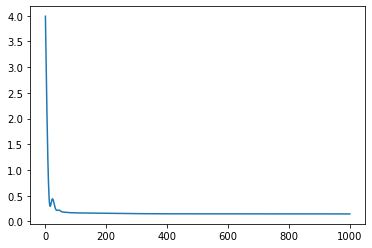

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses);

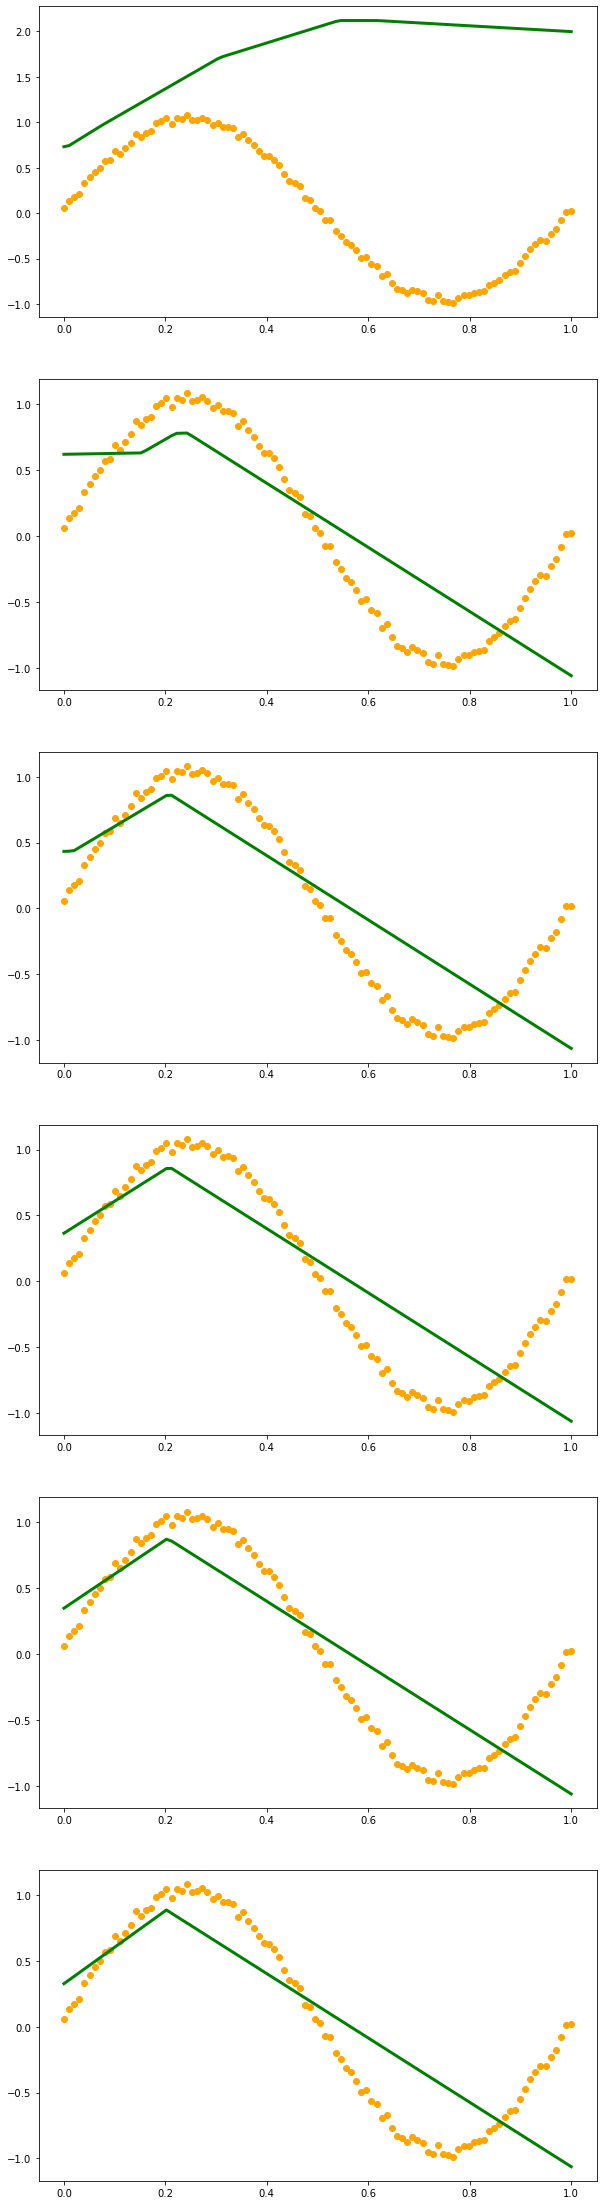

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(ys), 1, figsize=(10, 40))
for ax, y_ in zip(axs, ys):
    ax.scatter(X.numpy(), y.numpy(), color = "orange")
    ax.plot(X.numpy(), y_.detach().numpy(), 'g-', lw=3)

## 3.3 Построение сетей при помощи `torch.nn`

In [ ]:
import torch.nn as nn
import torch
import numpy as np

3.3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim`

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet, self).__init__()
        self.fc1 = nn.Linear(1, n_hidden_neurons)

        # поэкспериментировать с другиями функциями активации

        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

sine_net = SineNet(50)

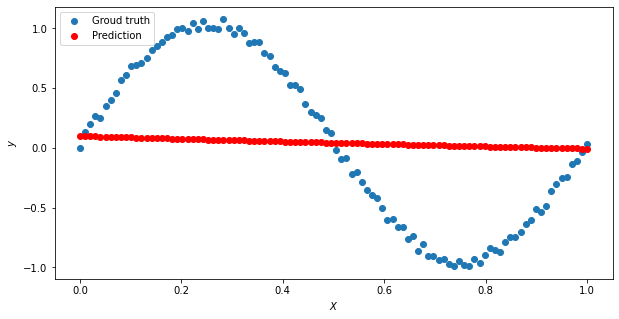

In [ ]:
import matplotlib.pyplot as plt

def predict(net, X, y):
        y_pred = net.forward(X)

        plt.figure(figsize=(10, 5))
        plt.plot(X.numpy(), y.numpy(), 'o', label='Groud truth')
        plt.plot(X.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
        plt.legend(loc='upper left')
        plt.xlabel('$X$')
        plt.ylabel('$y$')

predict(sine_net, X, y)

In [ ]:
optimizer = torch.optim.Adam(sine_net.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

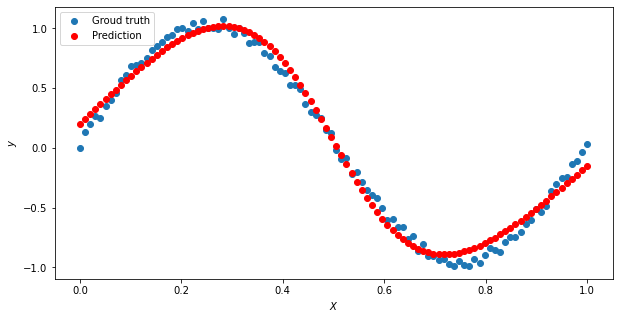

In [ ]:
for epoch_index in range(1001):
    optimizer.zero_grad()

    y_pred = sine_net.forward(X)
    loss_val = criterion.forward(y_pred, y)

    loss_val.backward()

    optimizer.step()

predict(sine_net, X, y)

3.3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim`

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

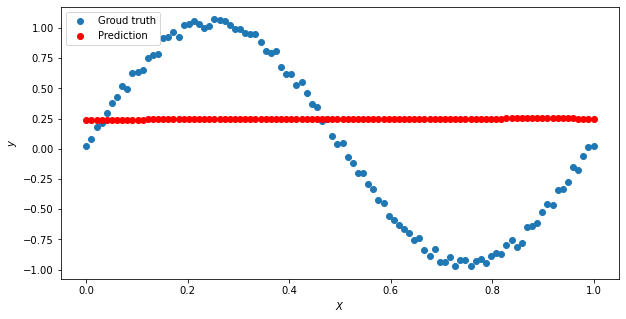

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 50),
    nn.Sigmoid(),
    nn.Linear(50,1)
)
predict(model, X, y)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

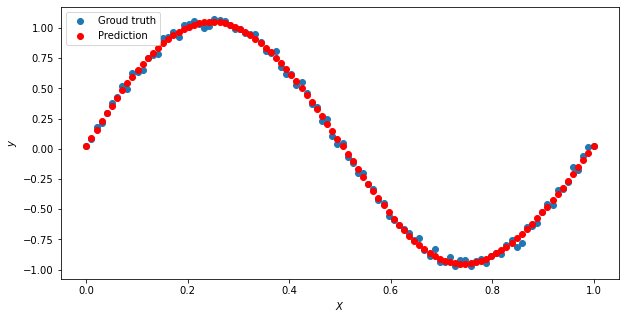

In [ ]:
for epoch_index in range(3000):

    y_pred = model.forward(X)
    loss_val = criterion.forward(y_pred, y)

    loss_val.backward()

    optimizer.step()
    optimizer.zero_grad()

predict(model, X, y)

## 3.4. Datasets and dataloaders

In [ ]:
from torch.utils.data import Dataset, DataLoader

3.4.1 Создать датасет, поставляющий данные из задачи 3.1.2.

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.3.1 (или 3.3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [ ]:
class SinDataset(Dataset):
    def __init__(self):
        self.n_samples = X.shape[0]
        self.X = X
        self.y = y

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

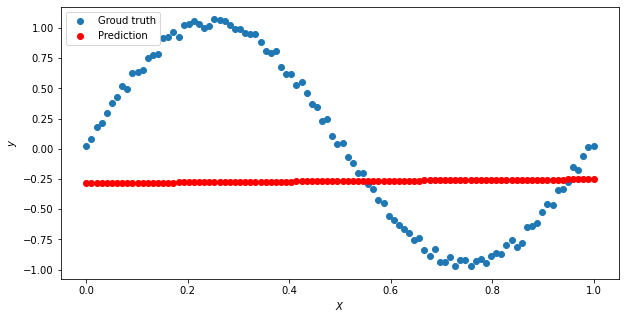

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 50),
    nn.Sigmoid(),
    nn.Linear(50,1)
)
dataset = SinDataset()
dataloader = DataLoader(dataset, batch_size=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')
predict(model, X, y)

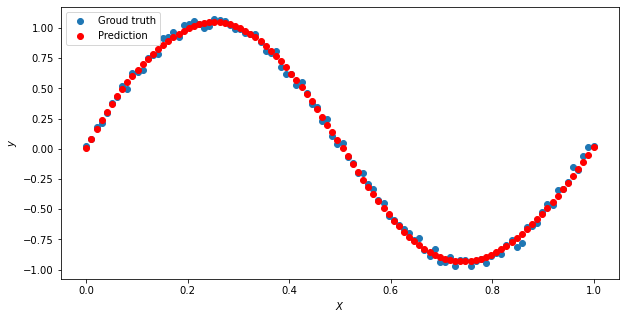

In [ ]:
for epoch_index in range(3000):
    for x_example, y_example in dataloader:
        optimizer.zero_grad()

        y_pred = model.forward(x_example)
        loss_val = criterion.forward(y_pred, y_example)

        loss_val.backward()

        optimizer.step()

predict(model, X, y)

3.4.2 Предсказание цен алмазов

3.4.2.1 Создайте датасет на основе файла diamonds.csv.

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

3.4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.

3.4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`).

3.4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке.

In [ ]:
import pandas as pd

diamonds = pd.read_csv('diamonds.csv', index_col=0)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
class DiamondsDataset(Dataset):
    def __init__(self, data):
        data = data.select_dtypes(exclude='object')
        self.data_x = torch.from_numpy(data.drop("price", axis=1).values).float()
        self.data_y = torch.from_numpy(data[["price"]].values).float()
        self.n_samples = self.data_x.shape[0]


    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.data_x[idx], self.data_y[idx]

In [ ]:
dataset = DiamondsDataset(diamonds)
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])
dataloader = DataLoader(dataset=train, batch_size=256)

model = nn.Sequential(
    nn.BatchNorm1d(dataset.data_x.shape[-1]),
    nn.Linear(dataset.data_x.shape[-1], 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100,1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

In [ ]:
losses_all = []
for epoch in range(101):
    losses = torch.empty(0)
    for x_example, y_example in dataloader:
        y_pred = model(x_example)
        loss = criterion(y_pred, y_example)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = torch.cat((losses, loss.view(1)))

    if epoch % 25 == 0:
        print('epoch', epoch, 'loss', losses.mean().item())
    losses_all.append(losses.mean().item())

epoch 0 loss 2042450432.0
epoch 25 loss 545825728.0
epoch 50 loss 536641472.0
epoch 75 loss 516557664.0
epoch 100 loss 507345248.0


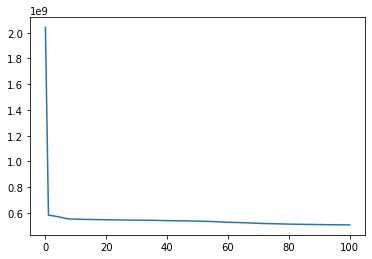

In [ ]:
plt.plot(losses_all);

In [ ]:
dataloader = DataLoader(dataset=test, batch_size=256)
losses = torch.empty(0)
for x_example, y_example in dataloader:
    y_pred = model(x_example)
    loss = criterion(y_pred, y_example)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses = torch.cat((losses, loss.view(1)))

print(losses.mean().item())

515759936.0


In [ ]:
dataset.__getitem__(0)

(tensor([ 0.2300, 61.5000, 55.0000,  3.9500,  3.9800,  2.4300]),
 tensor([326.]))

3.4.3 Модифицируйте метод `__init__` датасета из 3.4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [ ]:
class DiamondsDataset(Dataset):
    def __init__(self, data, transform):
        self.n_samples = data.shape[0]
        self.transform = transform
        self.x_data = data.drop("price", axis=1).values
        self.y_data = data[["price"]].values

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):

        sample = self.x_data[idx], self.y_data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class DropColsTransform:
    def __init__(self, drop):
        self.drop = drop

    def __call__(self, sample):
        X, y = sample
        X = np.delete(X, self.drop, 0)
        return X, y

In [ ]:
class ToTensorTransform:
    def __call__(self, sample):
        X, y = sample
        X = torch.from_numpy(X.astype("float")).float().view(-1)
        y = torch.from_numpy(y.astype("float")).float().view(-1)
        return X, y

In [ ]:
from torchvision import transforms

drop = DropColsTransform(drop=[1, 2, 3])
to_tensor = ToTensorTransform()
dataset = DiamondsDataset(diamonds, transforms.Compose([drop, to_tensor]))

In [ ]:
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])
dataloader = DataLoader(dataset=train, batch_size=256)

model = nn.Sequential(
    nn.BatchNorm1d(6),
    nn.Linear(6, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100,1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss(reduction='sum')

epoch 0 loss 2168790784.0
epoch 25 loss 532973056.0
epoch 50 loss 515969344.0
epoch 75 loss 505501568.0
epoch 100 loss 501439584.0


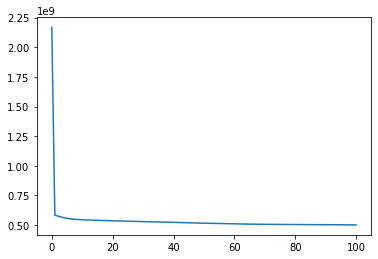

In [ ]:
losses_all = []
for epoch in range(101):
    losses = torch.empty(0)

    for x_example, y_example in dataloader:
        y_pred = model(x_example)
        loss = criterion(y_pred, y_example)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = torch.cat((losses, loss.view(1)))



    if epoch % 25 == 0:
        print('epoch', epoch, 'loss', losses.mean().item())
    losses_all.append(losses.mean().item())
plt.plot(losses_all);

In [ ]:
dataloader = DataLoader(dataset=test, batch_size=256)
losses = torch.empty(0)
for x_example, y_example in dataloader:
    y_pred = model(x_example)
    loss = criterion(y_pred, y_example)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses = torch.cat((losses, loss.view(1)))

print(losses.mean().item())

521602080.0
